Flinks Data Scientist - Technical Test
=============================

Exercise 1: Machine Learning Model
----------
**Description :**

Using the following link, you will get access to a dataset from Kickstarter. The goal of this exercies is to be able to predict as much as possible if a project will get backer's sufficient funding before deadline.
Link: https://drive.google.com/file/d/17_mwpPzHlvMIs2n5wOwOV30JfNRnlFCx/view?usp=sharing
Using this dataset, please develop a statistical model that predicts which projects will be funded. The exercise is not to obtain the best performance, but more to have a logical and well thought model.
The expected output format is a notebook that shows both your code and your thinking process.
Note: it is up to to define whether a project has been funded or not, using the data at hand

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier

with open('ks-projects-201612.csv', encoding="utf8", errors='ignore') as file:
    reader = csv.reader(file)
    data_set = list(reader)
data_set = np.array(data_set)

**Utils**

In [2]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
    d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
    return abs((d2 - d1).days)

In [3]:
header = data_set[0]
data_set = data_set[1:len(data_set)] #data set without the header
print(header)

['ID ' 'name ' 'category ' 'main_category ' 'currency ' 'deadline '
 'goal ' 'launched ' 'pledged ' 'state ' 'backers ' 'country '
 'usd pledged ' '' '' '' '']
['ID ' 'name ' 'category ' 'main_category ' 'currency ' 'deadline '
 'goal ' 'launched ' 'pledged ' 'state ' 'backers ' 'country '
 'usd pledged ' '' '' '' '']


Data cleaning 
--------

The first step is to clean the data set:

We delete rows 
 - which doesn't match the correct format 
 - which had a goal too hight or too low (here we delete rows where goal value is <20 and >1 000 000)
 - where the state is different from 'failed' or 'successful'

In [4]:
def clean_data_set(data_set):
    ti = time.time()
    delete_lines = []
    for i in range(len(data_set)):
        if isfloat(data_set[i, 6]) == False or data_set[i, 9] not in ['failed', 'successful']:
            delete_lines.append(i)
        elif float(data_set[i,6]) > 1000000 or float(data_set[i,6])< 20:
            delete_lines.append(i)
    data_set = np.delete(data_set, (delete_lines), axis=0)
    tf = time.time()
    print("temps : " + str(tf - ti))
    return data_set

data_set = clean_data_set(data_set)

temps : 2.1521060466766357
temps : 2.1521060466766357


In [5]:
data_set_size = len(data_set)

In [6]:
data_set_output = data_set[:,9]

In [7]:
list_of_output = []
for j in range(len(data_set_output)):
    if data_set_output[j] not in list_of_output:
        list_of_output.append(data_set_output[j])

list_of_output

['failed', 'successful']

['failed', 'successful']

In [8]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
    d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
    return abs((d2 - d1).days)

Build the input layer
---------------------
We create two versions of the input layer : 
   - 1 : Where non numeric inputs are labelencoded (with a value between 0 and 1) 
   - 2 : Where non numeric inputs are onehotencoded 

In [9]:
import time
def build_input_layer(data_set):
    ti = time.time()
    goal = np.zeros((len(data_set)))
    time_allowed = np.zeros((len(data_set)))
    for i in range (len(data_set)):
        if isfloat(data_set[i,6]):
            time_allowed[i]= days_between(data_set[i][7],data_set[i][5]) #time allowed to get the money
            goal[i] = float(data_set[i][6]) #the goal
    labelencoder = LabelEncoder() 
    onehot_encoder = OneHotEncoder(sparse=False)
    
    #encode category
    label_encoded_category=labelencoder.fit_transform(data_set[:,2])
    int_encoder = label_encoded_category.reshape(len(data_set[:,2]), 1)
    onehot_encoded_category = onehot_encoder.fit_transform(int_encoder)
  
    #encode main category
    label_encoded_main_category=labelencoder.fit_transform(data_set[:,3])
    int_encoder = label_encoded_main_category.reshape(len(data_set[:,3]), 1)
    onehot_encoded_main_category = onehot_encoder.fit_transform(int_encoder)

    #encode country
    label_encoded_country=labelencoder.fit_transform(data_set[:,4])
    int_encoder = label_encoded_country.reshape(len(data_set[:,4]), 1)
    onehot_encoded_country = onehot_encoder.fit_transform(int_encoder)
  
    print (time_allowed.shape)
    print (goal.shape)
    print (np.reshape(label_encoded_category,(len(data_set),1)).shape)
    print (label_encoded_main_category.shape)
    print (label_encoded_country.shape)
    
    print (onehot_encoded_category.shape)
    print (onehot_encoded_main_category.shape)
    print (onehot_encoded_country.shape)
    
    #concatenate values label
    input_data_set_label_encoded = np.concatenate((np.reshape(time_allowed,(len(data_set),1)),
                                                    np.reshape(goal,(len(data_set),1)),
                                                    np.reshape(label_encoded_category,(len(data_set),1)),
                                                    np.reshape(label_encoded_main_category,(len(data_set),1)),
                                                    np.reshape(label_encoded_country,(len(data_set),1))),axis=1)


    #concatenate values onehot
    input_data_set_one_hot_encoded = np.concatenate((np.reshape(time_allowed,(len(data_set[:,0]),1))
                                                    ,np.reshape(goal,(len(data_set[:,1]),1)),
                                                    onehot_encoded_category, onehot_encoded_main_category,
                                                    onehot_encoded_country),axis=1)
    
    tf = time.time()
    print("temps : " +str(tf-ti))
    return input_data_set_label_encoded, input_data_set_one_hot_encoded

In [10]:
input_data, input_data_one_hot_encoded = build_input_layer(data_set)
print (input_data_one_hot_encoded.shape)
print(input_data.shape)

/anaconda3/envs/env_tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/anaconda3/envs/env_tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "ca

(279481,)
(279481,)
(279481, 1)
(279481,)
(279481,)
(279481, 158)
(279481, 15)
(279481, 13)
(279481,)
(279481,)
(279481, 1)
(279481,)
(279481,)
(279481, 158)
(279481, 15)
(279481, 13)
temps : 10.592612981796265
(279481, 188)
(279481, 5)
temps : 10.592612981796265
(279481, 188)
(279481, 5)


19511.754124788444

19511.754124788444

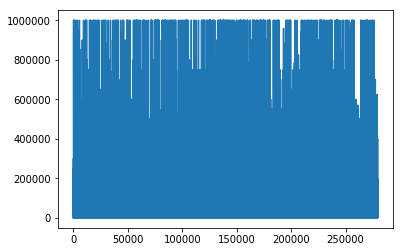

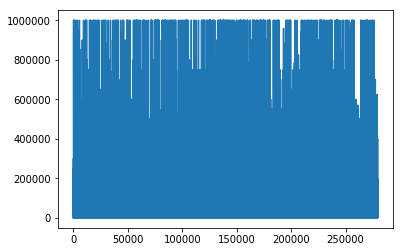

In [11]:
plt.plot(input_data[:,1])
np.mean(input_data[:,1])

In [12]:
#normalize the input_data
#max date time
max_date = max(input_data[:,0])
#max goal 
max_goal =max(input_data[:,1])
#max main categorie
max_categorie = max(input_data[:,2])
#max categorie
max_main_categorie = max(input_data[:,3])
#max country
max_country = max(input_data[:,3])
#max currency
#max_currency = max(input_data[:,5])

In [13]:
def normalize_input_data(input_data):
    input_data[:,0] = np.divide(input_data[:,0],max_date)#*100
    input_data[:,1] = np.divide(input_data[:,1],max_goal)#*100
    input_data[:,2] = np.divide(input_data[:,2],max_categorie)#*100
    input_data[:,3] = np.divide(input_data[:,3],max_main_categorie)
    input_data[:,4] = np.divide(input_data[:,3],max_country)#*100
    #input_data[:,5] = np.divide(input_data[:,5],max_currency)
    
    return input_data

input_data = normalize_input_data(input_data)

In [14]:
def normalize_input_data_one_hot(input_data):
    input_data[:,0] = np.divide(input_data[:,0],max_date)#*100
    input_data[:,1] = np.divide(input_data[:,1],max_goal)#*100
    return input_data
input_data_one_hot_encoded = normalize_input_data_one_hot(input_data_one_hot_encoded)

In [15]:
def build_target_layer(data_set):
    target_data = np.zeros(len(data_set))
    for i in range (len(data_set)):
        if data_set[i,9]=='failed':
            target_data[i] = 0
        else :
            target_data[i]= 1
    return target_data
target_data = build_target_layer(data_set)

Split the data set
----

We split the data set in two parts : 
   - train_data_set
   - test_data_set

In [16]:
train_data_set_size = 200000
test_data_set_size = 50000
train_input_data = input_data[0:train_data_set_size]
test_input_data = input_data[train_data_set_size + 1 : train_data_set_size + test_data_set_size]

train_target_data = target_data[0:train_data_set_size]
test_target_data = target_data[train_data_set_size + 1 : train_data_set_size + test_data_set_size]

In [17]:
train_input_data_one_hot_encoded = input_data_one_hot_encoded[0:train_data_set_size]
test_input_data_one_hot_encoded = input_data_one_hot_encoded[train_data_set_size + 1 : train_data_set_size + test_data_set_size]

Logistic regression, random forest and neural network with label encoded : 
----

In [18]:
#Logistic regression
log_reg = LogisticRegression()
log_reg.fit(train_input_data,train_target_data)
print("Accuracy with logistic regression " + str(log_reg.score(test_input_data,test_target_data)*100) + " %")

/anaconda3/envs/env_tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/env_tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with logistic regression 61.041220824416484 %
Accuracy with logistic regression 61.041220824416484 %


In [ ]:
#Random forest
rdf = RandomForestClassifier(n_estimators=200)
rdf.fit(train_input_data,train_target_data)
print("Accuracy with random forest regression " + str(rdf.score(test_input_data,test_target_data)*100) + " %")

Accuracy with random forest regression 64.50129002580051 %
Accuracy with random forest regression 64.50129002580051 %


In [ ]:
#Neural network
clf = MLPClassifier(solver='lbfgs', alpha=1e-05,
                     hidden_layer_sizes=(30, 10), random_state=1, learning_rate_init=0.1)
clf.fit(train_input_data, train_target_data)
print("Accuracy with neural network " +str(clf.score(test_input_data,test_target_data)*100) + " %")

Logistic regression, random forest and neural network with one hot encoded input :
---

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(train_input_data_one_hot_encoded,train_target_data)
print("Accuracy with logistic regression " + str(log_reg.score(test_input_data_one_hot_encoded,test_target_data)*100) + " %")

In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-05,
                     hidden_layer_sizes=(30, 10), random_state=1)
clf.fit(train_input_data_one_hot_encoded, train_target_data)  
print("Accuracy with neural network " +str(clf.score(test_input_data_one_hot_encoded,test_target_data)*100) + " %")

In [ ]:
rdf = RandomForestClassifier(n_estimators=200)
rdf.fit(train_input_data_one_hot_encoded,train_target_data)
print("Accuracy with random forest "+ str(rdf.score(test_input_data_one_hot_encoded,test_target_data)*100) + " %")